In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

sns.set(font_scale=1.2)
sns.set_style('whitegrid')
#%matplotlib inline

In [2]:
model_testing = 'y'
data_checks = 'n' # y -> visualize data and correlation plots (it takes a while to execute the merged pairplot)
remove_outliers = False

In [3]:
# beautifiers
sns.set_style('whitegrid')#, {"font.family":['Optima']})
sns.set_context('talk', font_scale=2.5)

font = {'family' : 'Optima'}#,
#       'weight' : 'bold',
#       'size'   : 18}

unitocolor = '#EA0029'
unitogray  = '#54565A'
faircolor  = '#FDBB63'

# Create an array with the colors you want to use
colors = [unitocolor, unitogray]
# Set your custom color palette
unitopalette = sns.set_palette(sns.color_palette(colors))

# Dataset W -> e + nu
Run number of the event, Event number, pt eta phi are the electron's kinematics variables, Q is electron's charge, type is where they found the electron (in the barrel or the endcap), the del- features and sigmaEtaEta are the differences between the track variable and the one of the cluster, HoverE is the ratio of the electron's energy measured HCAL/ECAL, iso are parameters associated to electron detection, MET features refer to the kinematics of the neutrino

In [4]:
dfenu_raw = pd.read_csv('~/Documents/tesi/thesis_notebooks/input_datasets/Wenu.csv')
dfenu_raw['type'] = dfenu_raw['type'].map({'EB': 0, 'EE': 1})

In [4]:
dfenu_raw.info()
dfenu_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Run          100000 non-null  int64  
 1   Event        100000 non-null  int64  
 2   pt           100000 non-null  float64
 3   eta          100000 non-null  float64
 4   phi          100000 non-null  float64
 5   Q            100000 non-null  int64  
 6   type         100000 non-null  int64  
 7   delEta       100000 non-null  int64  
 8   delPhi       100000 non-null  int64  
 9   sigmaEtaEta  100000 non-null  float64
 10  HoverE       100000 non-null  float64
 11  isoTrack     100000 non-null  float64
 12  isoEcal      100000 non-null  float64
 13  isoHcal      100000 non-null  float64
 14  MET          100000 non-null  float64
 15  phiMET       100000 non-null  float64
dtypes: float64(10), int64(6)
memory usage: 12.2 MB


,Run,Event,pt,eta,phi,Q,type,delEta,delPhi,sigmaEtaEta,HoverE,isoTrack,isoEcal,isoHcal,MET,phiMET
0,167676,328843401,38.6387,-0.8499,1.8486,-1,0,0,0,0.0095,0.0000,0.0000,1.2241,0.0000,46.7884,-1.3886
1,167676,328836311,59.1666,-2.1095,-2.5163,1,1,0,0,0.0214,0.0177,20.4771,2.5441,6.7450,15.0179,1.1503
2,167676,328915343,31.7262,2.4504,2.8956,1,1,0,0,0.0288,0.0000,0.7775,1.8222,0.3663,20.6550,-0.2703
3,167676,328884653,73.4109,-1.3951,2.0052,-1,0,0,0,0.0100,0.0000,22.8584,8.0151,8.2951,3.2858,-0.7739
4,167676,328970109,49.1363,-2.4326,3.0219,1,1,0,0,0.0271,0.0000,0.0000,0.1154,0.0000,3.1425,2.5081


In [51]:
# to uniform datasets
dfenu_raw['iso'] = dfenu_raw.apply(lambda x: x['isoTrack'] + x['isoEcal'] + x['isoHcal'],axis=1)

In [5]:
dfenu_raw = dfenu_raw[['Run', 'Event', 'pt', 'eta', 'phi', 'Q', 'MET', 'phiMET']]

## Data visualization (W -> e + nu)

In [7]:
if data_checks=='y':
    # aesthetics
    plt.figure(figsize=(20, 10)) 
    sns.set(font_scale=1.0)
    # boxplot
    sns.boxplot(data=dfenu_raw, orient="h", whis=1.5)

**Boxplot comment**: `pt` e `MET` are the only ones that present *outliers* between the features of interest.

**The coloured rectangle covers the range 25-75 percentile, while the whiskers reach to 1.5 times the distance between 25-75th percentile in both directions (starting from the median)**

## Removing outliers

In [6]:
dfe = dfenu_raw

if remove_outliers:
#   cutoff_pt_e = dfe['pt'].quantile(.95)
#   cutoff_MET_e = dfe['MET'].quantile(.95)
    cutoff_pt_e = 260
    cutoff_MET_e = 100
    dfe = dfe[(dfe['pt']<cutoff_pt_e) & (dfe['MET']<cutoff_MET_e)]
    
    print(f"Total number of data points:\t\t{len(dfenu_raw)}")
    # for troubleshooting
    # excluded_e = dfenu_array_to_dfenu[(dfenu_array_to_dfenu['pt']>cutoff_scal_pt_e) | (dfenu_array_to_dfenu['MET']>cutoff_scal_MET_e)]
    print(f"Data points after filtering outliers:\t {len(dfe)} ({len(dfe)/len(dfenu_raw)*100:2.2f}%)")

In [9]:
if data_checks=='y':
# for a uniform visualization, linearly scaling the data between 0 and 1
    scaler = preprocessing.MinMaxScaler()
    dfenu_scaled = scaler.fit_transform(dfe)
    dfe_array_to_df = pd.DataFrame(dfenu_scaled, columns = dfenu_raw.columns)
    # aesthetics
    plt.figure(figsize=(20, 10)) 
    sns.set(font_scale=1.0)
    # boxplot
    sns.boxplot(data=dfe_array_to_df, orient="h", whis=1.5)

**NEW boxplot comment**: pt still shows data points out of the whiskers but due to their number, the results of the training, and the sake of keeping as much data as possible they will be kept and considered throughout the analysis

In [10]:
if data_checks=='y':
    fig, ax = plt.subplots(figsize=(20,20))
    # sns.set(font_scale=1.0)
    sns.heatmap(dfe_array_to_df.corr() , annot= True, linewidths=2, ax=ax, cmap='mako')

In [11]:
# Checking for higher order correlations (this will be repeated after merging the 2 different datasets)
if data_checks=='y':
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2.0)
    fig_pairplot_e = sns.pairplot(dfe_array_to_df) # diag_kind='kde'

In [12]:
#fig_pairplot_e.savefig('pairplot_enu.pdf')
#fig_pairplot_e.savefig('pairplot_enu.png')

**Pairplot comment**: the features don't exhibit evident patters, they all seem to carry independent information

In [7]:
# Adding 'class' because of dataset merging 
class_col = []
for i in range(len(dfe['pt'])):
    class_col.append('enu')
    
dfe.loc[:,'class'] = class_col

In [9]:
dfe.head()

,pt,eta,phi,Q,MET,phiMET,class
0,38.6387,-0.8499,1.8486,-1,46.7884,-1.3886,enu
1,59.1666,-2.1095,-2.5163,1,15.0179,1.1503,enu
2,31.7262,2.4504,2.8956,1,20.6550,-0.2703,enu
3,73.4109,-1.3951,2.0052,-1,3.2858,-0.7739,enu
4,49.1363,-2.4326,3.0219,1,3.1425,2.5081,enu


# Dataset W -> mu + nu
**Feature comment**: `chisq` is divided by dof, the kinematics features come from fits on data so chisq abnormally high should just be left out of the training of the network, because even if they were decay events they exhibit a peculiar behaviour (like outliers) and the network is not designed to take care of such fine phenomena, `dxy` is the impact parameter, the `iso` parameter represents the threshold for the cluster to be identifyed as the trace/sign of an muon 

In [8]:
dfmunu_raw = pd.read_csv('~/Documents/tesi/thesis_notebooks/input_datasets/Wmunu.csv')

In [16]:
dfmunu_raw.info()
dfmunu_raw.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Run     100000 non-null  int64  
 1   Event   100000 non-null  int64  
 2   pt      100000 non-null  float64
 3   eta     100000 non-null  float64
 4   phi     100000 non-null  float64
 5   Q       100000 non-null  int64  
 6   chiSq   100000 non-null  float64
 7   dxy     100000 non-null  float64
 8   iso     100000 non-null  float64
 9   MET     100000 non-null  float64
 10  phiMET  100000 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 8.4 MB


,Run,Event,pt,eta,phi,Q,chiSq,dxy,iso,MET,phiMET
9443,172822,1762442150,33.9089,1.5356,-2.3009,-1,0.8707,0.0148,8.0856,18.9251,-2.0359
17578,171446,404841020,29.9276,-0.2536,0.7619,1,1.2921,-0.0200,17.1291,9.7526,2.2328
4348,172822,1739247226,32.1501,1.6052,-2.9429,1,0.6720,-0.0773,5.7787,23.4991,-0.1894


Let's get rid of the events with an high chisq

In [9]:
chisq_th = 10 # threshold for acceptance of the data. It is a reduced chi squared!
not_trustworthy = dfmunu_raw[dfmunu_raw['chiSq'] > chisq_th]
dfmunu_raw.drop(not_trustworthy.index, inplace=True)
len(not_trustworthy)

4802

In [10]:
# keep only features of interest
dfmunu_raw = dfmunu_raw[['Run', 'Event', 'pt', 'phi', 'eta', 'Q', 'MET', 'phiMET']]

## Data visualization (W -> mu + nu)

## Removing outliers

In [11]:
dfmu = dfmunu_raw

if remove_outliers:
#   cutoff_pt_mu = dfmunu_raw['pt'].quantile(.95)
#   cutoff_MET_mu = dfmunu_raw['MET'].quantile(.95)
    cutoff_pt_mu = 170
    cutoff_MET_mu = 155
    dfmu = dfmu[(dfmu['pt']<cutoff_pt_mu) & (dfmu['MET']<cutoff_MET_mu)]
    print(f"Total number of data points:\t\t{len(dfmunu_raw)}")
    print(f"Data points after filtering outliers:\t{len(dfmu)} ({len(dfmu)/len(dfmunu_raw)*100:2.2f}%)")

**Boxplot comment**: `pt` and `MET` are the only relevant features that exhibit outliers

In [20]:
if data_checks=='y':
    scaler = preprocessing.MinMaxScaler()
    dfmunu_scaled = scaler.fit_transform(dfmu)
    dfmu_array_to_df = pd.DataFrame(dfmunu_scaled, columns = dfmunu_raw.columns)
    # aesthetics
    plt.figure(figsize=(20, 10)) 
    sns.set(font_scale=1.0)
    # boxplot
    sns.boxplot(data=dfmu_array_to_df, orient="h")

**Boxplot comment**: `pt` and `MET` are the only relevant features that exhibit outliers

In [21]:
if data_checks=='y':
    fig, ax = plt.subplots(figsize=(20,20))
    sns.set(font_scale=1.0)
    sns.heatmap(dfmunu_array_to_dfmunu.corr() , annot= True, linewidths=3, ax=ax, cmap='mako')

**Heatmap comment**: no relevant (linear) correlations between the features manifest itself at this stage

In [22]:
if data_checks=='y':
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2.0)
    fig_pairplot_mu = sns.pairplot(dfmu) # diag_kind='kde'

In [23]:
#fig_pairplot_mu.savefig('pairplot_munu.pdf')
#fig_pairplot_mu.savefig('pairplot_munu.png')

In [12]:
# Adding 'class' because of dataset merging
class_col = []
for i in range(len(dfmu['pt'])):
    class_col.append('munu')
    
dfmu.loc[:,'class'] = class_col

# Merging data

In [13]:
df = pd.concat([dfe,dfmu], ignore_index=True, sort=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195198 entries, 0 to 195197
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Run     195198 non-null  int64  
 1   Event   195198 non-null  int64  
 2   pt      195198 non-null  float64
 3   eta     195198 non-null  float64
 4   phi     195198 non-null  float64
 5   Q       195198 non-null  int64  
 6   MET     195198 non-null  float64
 7   phiMET  195198 non-null  float64
 8   class   195198 non-null  object 
dtypes: float64(5), int64(3), object(1)
memory usage: 13.4+ MB


In [14]:
df.sample(10)

,Run,Event,pt,eta,phi,Q,MET,phiMET,class
95791,163817,618583904,28.1556,0.2466,0.4837,1,8.0622,1.7753,enu
122310,171446,428976640,30.3004,-1.3024,0.1575,-1,4.4974,0.2874,munu
87240,166514,320096492,51.9945,-1.7947,2.2075,1,30.6586,0.3565,enu
56675,163759,296206279,34.0908,-1.6438,2.3593,1,11.0665,-2.5819,enu
16573,172822,443728814,96.7635,-1.0204,-0.4778,1,2.2400,0.2512,enu
188226,172024,26638309,39.2492,-1.1690,-1.7698,1,55.7559,1.4873,munu
186026,172024,16368208,33.5480,0.3816,-2.0372,-1,25.8111,1.2595,munu
152858,166512,608809145,25.3383,1.3883,0.5157,1,38.8611,-2.2181,munu
171835,167674,318021844,28.3392,-0.0956,1.3732,-1,57.1395,-1.3816,munu
118120,171446,411249526,68.0022,-0.1299,0.3865,-1,7.8283,0.0455,munu


In [27]:
del dfenu_raw, dfmunu_raw # clean up

In [28]:
del dfe, dfmu # clean up

## Data checks

In [29]:
if data_checks=='y':
    sns.countplot(data=df,x='class')

<Figure size 2000x1000 with 0 Axes>

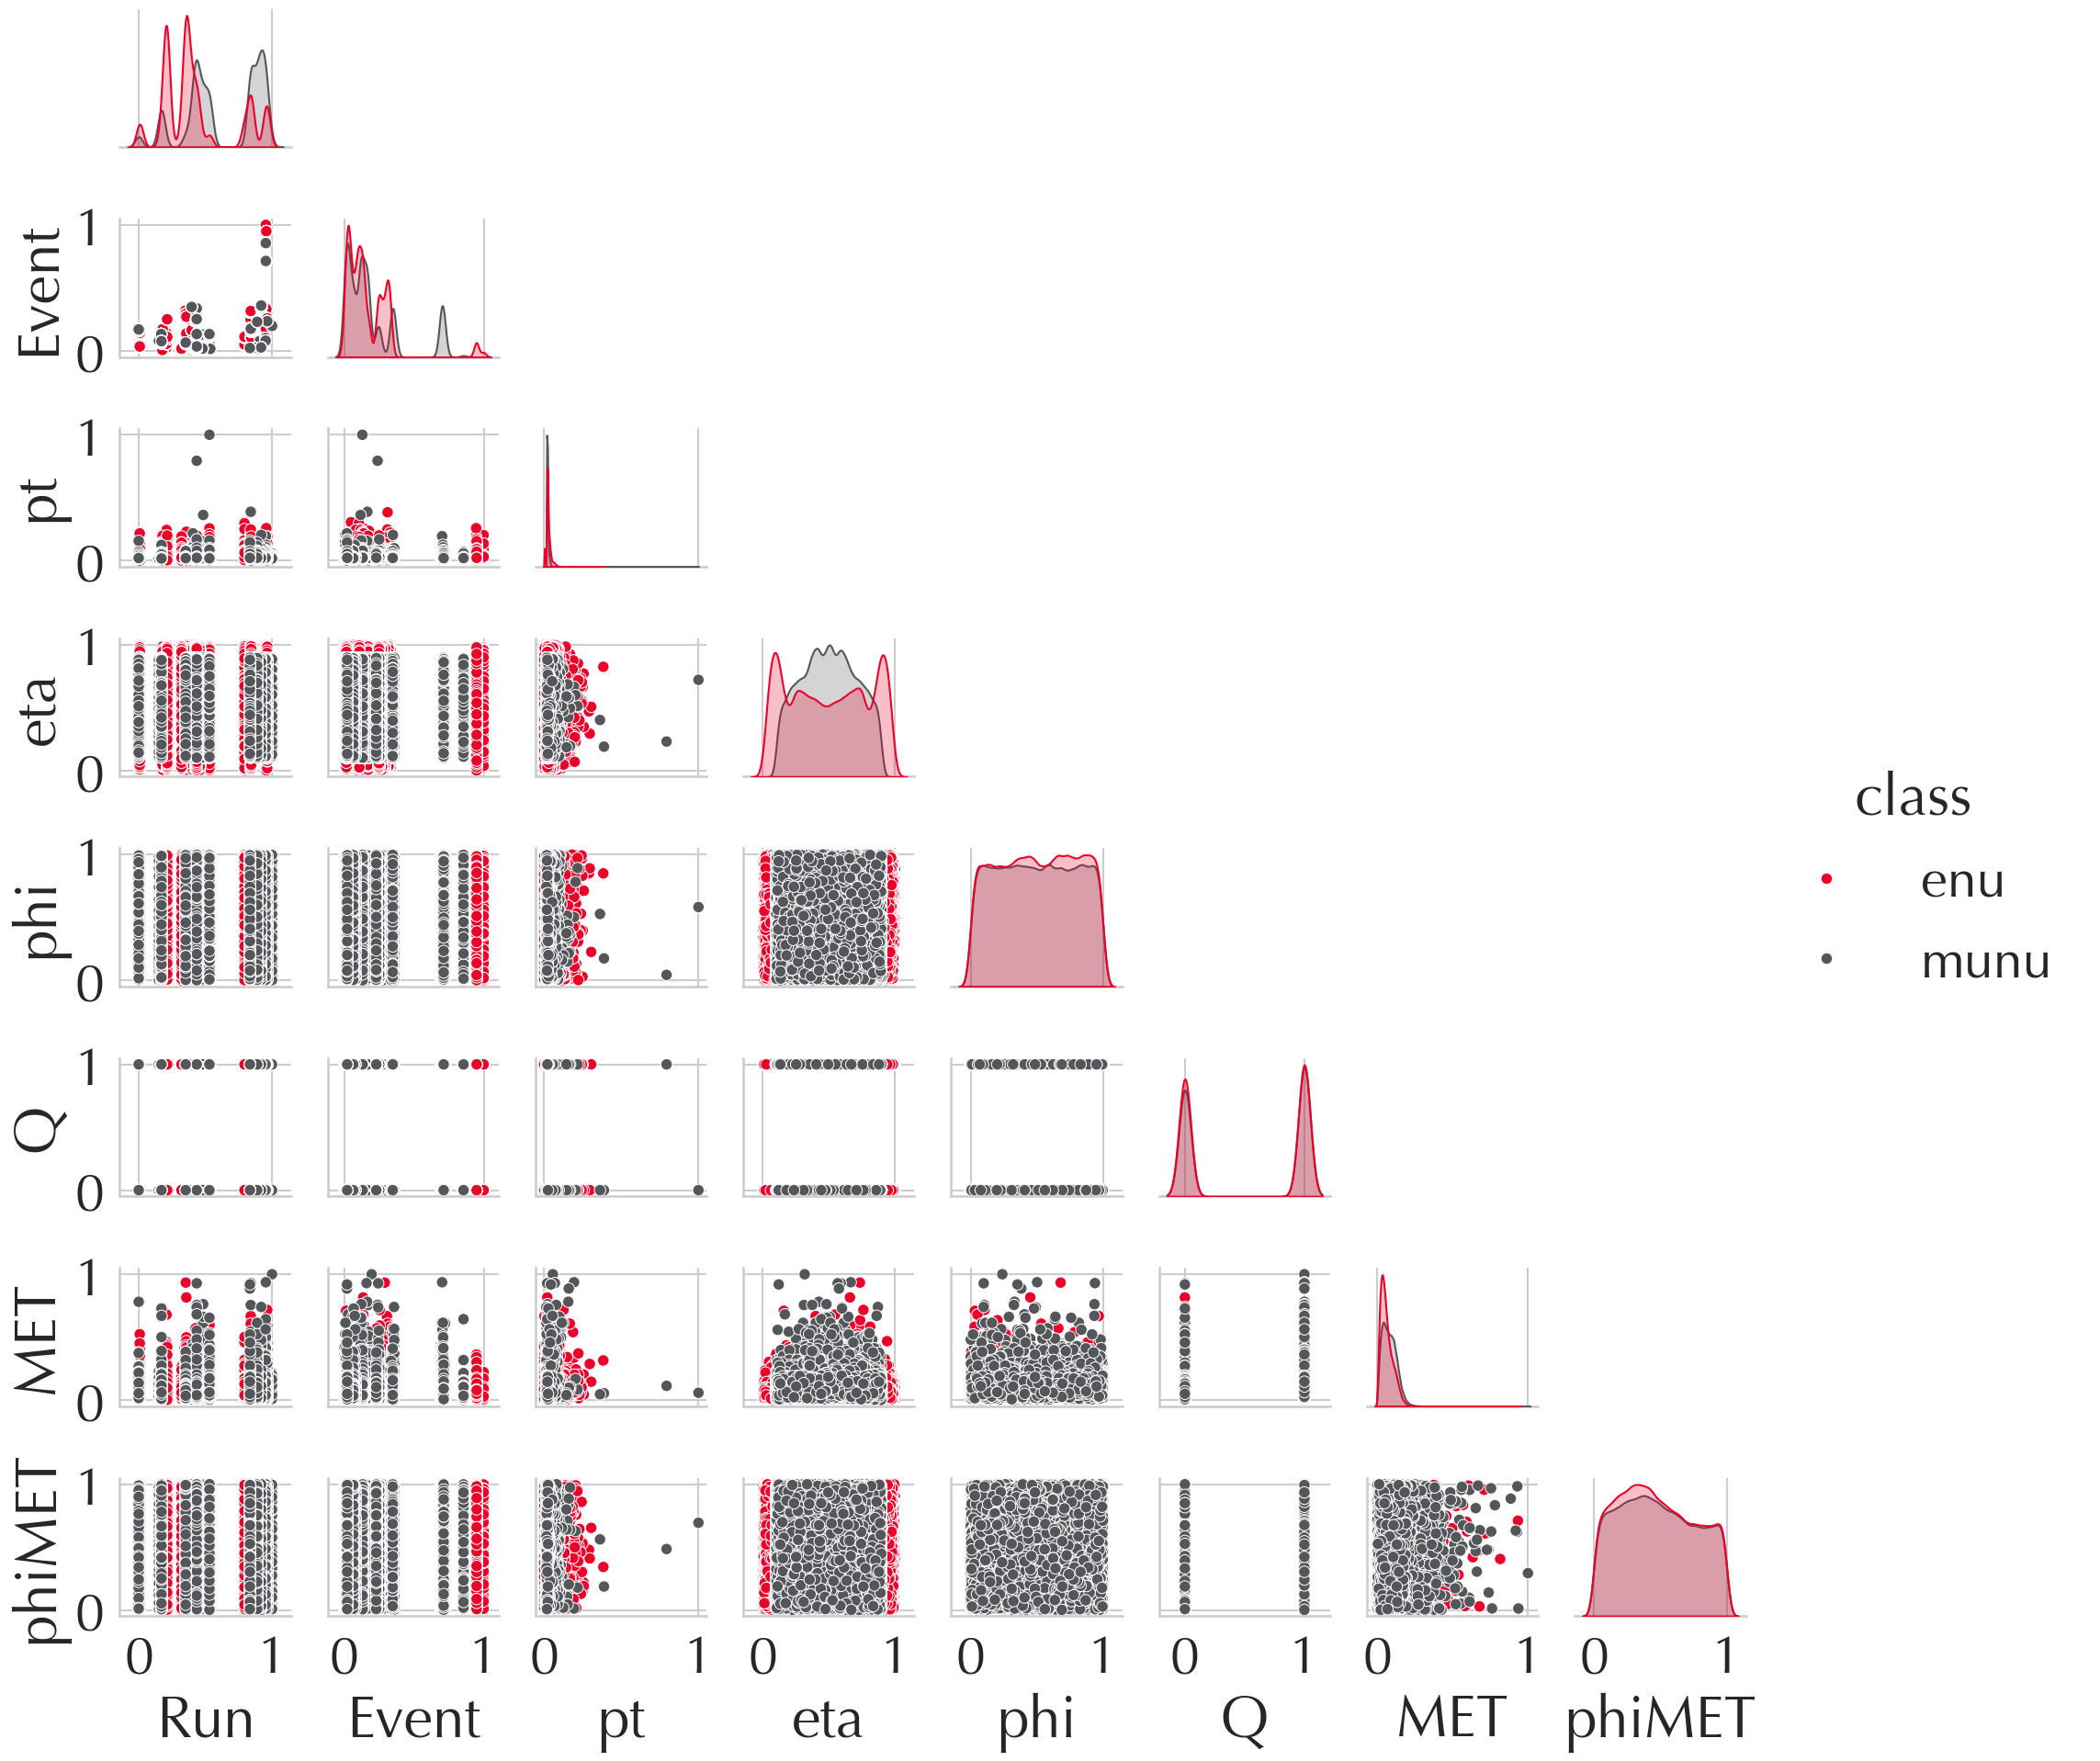

In [61]:
if data_checks=='y':
    df1 = df.copy()
    scaler = preprocessing.MinMaxScaler()
    df1['class'] = df1['class'].map({'enu': 0, 'munu': 1})
    df_scaled = scaler.fit_transform(df1) # normalization
    df_array_to_df = pd.DataFrame(df_scaled, columns = df.columns) # convert array into dataframe
    df_array_to_df['class'] = df['class']

    # beautifiers
    sns.set_style('whitegrid', {'font.family':'Optima'})
    sns.set_context('talk', font_scale=2.5)
    font = {'family' : 'Optima'}
    
    plt.figure(figsize=(20, 10))
    fig_pairplot_scaled = sns.pairplot(df_array_to_df, hue="class", corner=True, palette=unitopalette)

In [62]:
if data_checks=='y':
#   fig_pairplot_scaled.savefig('./Wmodels/Wpairplot_scaled_with_outliers.pdf', bbox_inches='tight')
    fig_pairplot_scaled.savefig('./Wmodels/Wpairplot_scaled_with_outliers.png', bbox_inches='tight')

**Merged Pairplot**: questo ha un'ulteriore utilità pké nonostante io abbia verificato che nn ci sono dipendenze evidenti separatamente tra le features, potenzialmente potrebbero esserci modi semplici di classificare sla base di poche feature (magari lo scatter tra 2 feature separa nettamente le 2 classi e quindi il problema di classificazione è immediatamente risolto). Effettivamente nn sembrano esserci maniere evidenti di risolvere il problema di classificazione a mano

## Dataset splitting (train, validation, test)

In [15]:
# Map class to int
df['class'] = df['class'].map({'enu': 0, 'munu': 1})

In [55]:
# Split labels from data
X = df.drop(['class'], axis=1)
y = df['class']

In [34]:
del df

In [56]:
# Removing test data from training
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.20, random_state=None) # this outputs pandas
# random_state initialized to an int makes the shuffling reproducible (fixes the random seed)

In [57]:
# train-validation split
X_train, X_validation, y_train, y_validation = train_test_split(X_other, y_other, test_size=0.20, random_state=0) # this outputs pandas

In [20]:
X_train.head()

,Run,Event,pt,eta,phi,Q,MET,phiMET
137960,167102,303940650,31.0501,0.4244,-0.0384,-1,34.0357,3.0660
124518,166161,51234389,40.0382,2.0501,-1.4823,1,35.7381,1.6717
172820,167674,323176453,81.0038,0.6939,1.3141,1,22.4093,-1.7684
147472,172400,878184237,26.6516,1.9954,-0.4478,1,3.0627,-1.7994
80345,165567,665601856,56.6125,-0.5617,0.6759,-1,32.1084,-2.8845


## Feature Scaling

**Standardizzazione** (0 mean and variance 1, but it's still a linear transformation, I'm not forcing the data to be normal!)

In [58]:
# Costruiamo il layer e informiamolo (ie ho solo 1 forma/STRUTTURA che adatto ai dati MA NN LO STO POPOLANDO!)
X_train_scaler = tf.keras.layers.Normalization(axis=-1) # axis=-1 gli dice come leggere il tensor ie in quale direz calcolare medie e varianze (qua banalmente se sle righe (axis=0) o sle colonne (axis=-1 o axis=1 fa li stès))
X_train_scaler.adapt(tf.convert_to_tensor(X_train)) # qua informiamo il layer sui dati, ie si calcola medie e varianze che userà poi

# The MODEL
**Hyperparameters** setup!

In [59]:
nepochs = 600
batch_size = 200
choosen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Architecture
nodes = [24, 12, 24]

choosen_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# we use "Sparse" because classes aren't represented with one hot encoding ie (0,1) e (1,0) but with integers 0 e 1
 
activation = 'sigmoid'

In [60]:
fig_name = './Wmodels/W'
for n in nodes:
    fig_name += str(n)
    fig_name += '_'
fig_name += 'Adam_' # REMEMBER TO CHANGE THIS!
fig_name += activation
fig_name

'./Wmodels/W24_12_24_Adam_sigmoid'

In [61]:
def my_model():
   model = tf.keras.Sequential([
    X_train_scaler,
    tf.keras.layers.Dense(nodes[0], activation=activation),
    tf.keras.layers.Dense(nodes[1], activation=activation),
#   tf.keras.layers.Dense(nodes[2], activation=activation),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)       
   ])
   model.compile(
                 optimizer=choosen_optimizer,
                 loss = choosen_loss,
                 metrics=['accuracy'])
 
   return model

model = my_model()

# Training

In [62]:
history = model.fit(X_train, y_train, epochs=nepochs, validation_data=(X_validation, y_validation), batch_size=batch_size)

Epoch 1/600
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.6540 - loss: 0.6382 - val_accuracy: 0.7282 - val_loss: 0.5625
Epoch 2/600
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.7333 - loss: 0.5579 - val_accuracy: 0.7355 - val_loss: 0.5552
Epoch 3/600
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.7385 - loss: 0.5485 - val_accuracy: 0.7392 - val_loss: 0.5471
Epoch 4/600
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - accuracy: 0.7414 - loss: 0.5421 - val_accuracy: 0.7523 - val_loss: 0.5370
Epoch 5/600
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.7553 - loss: 0.5299 - val_accuracy: 0.7664 - val_loss: 0.5227
Epoch 6/600
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.7754 - loss: 0.5105 - val_accuracy: 0.7778 - val_loss: 0.5016
Epoch 7/600
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.7775 - loss: 0.4954 - val_accuracy: 0.7763 - val_loss: 0.4848
Epoch 8/600
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.7780 - loss: 0

In [52]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 8)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349 (1.37 KB)

 Trainable params: 110 (440.00 B)

 Non-trainable params: 17 (72.00 B)

 Optimizer params: 222 (892.00 B)

## Performance check

1220/1220 - 0s - 298us/step - accuracy: 0.9980 - loss: 0.0073


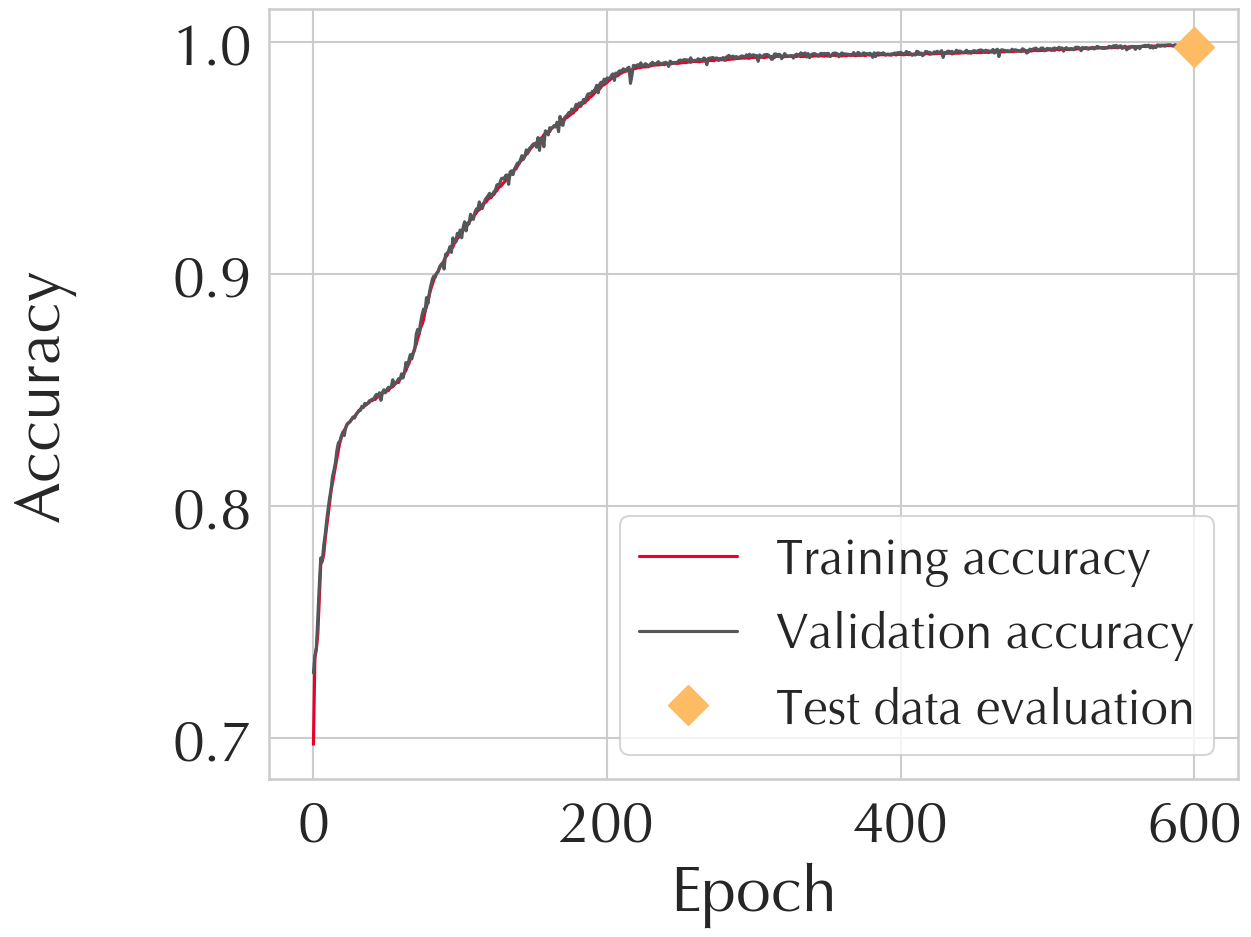

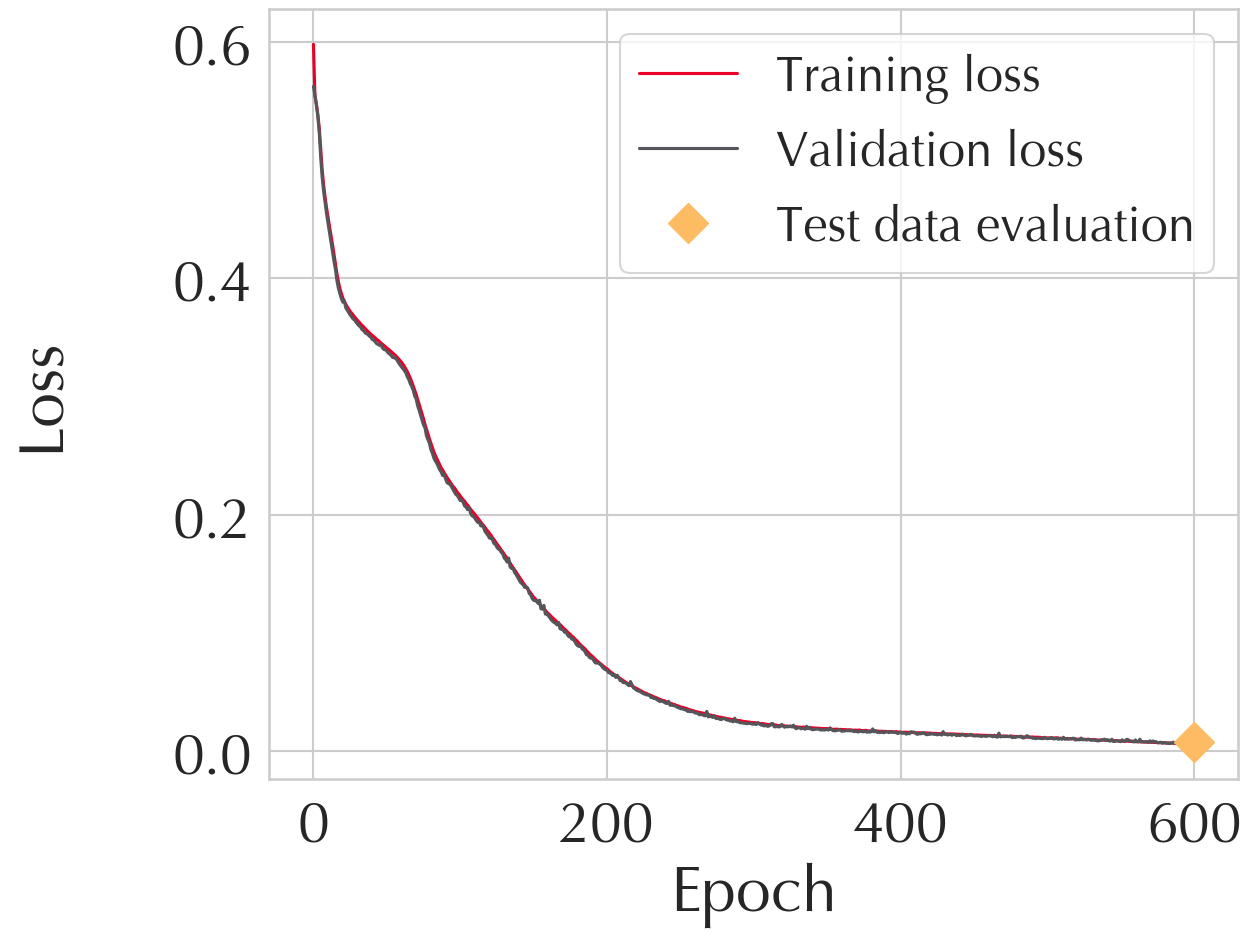

In [63]:
# aesthetics
sns.set_style('whitegrid')#, {"font.family":['Optima']})
sns.set_context('talk', font_scale=2.5)

font = {'family' : 'Optima'}#,
#      'weight' : 'normal',
#       'size'   : 18}

unitocolor = '#EA0029'
unitogray  = '#54565A'
faircolor  = '#FDBB63'

plt.rc('font', **font)

fig_acc_curve, ax1 = plt.subplots(figsize=(12.5,10))
fig_rock_curve, ax2 = plt.subplots(figsize=(12.5,10))

#fig = plt.figure(figsize=(25,10))
#ax1 = plt.subplot(121) # sta per 1,2,1 ie nrows, ncol, index
#ax2 = plt.subplot(122)

# what to plot on first figure (ax1)
ax1.plot(history.history['accuracy'], label='Training accuracy', color=unitocolor) # qua specifico cosa plottare (le y, le x sono implicite in history)
ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy', color=unitogray) 
#ax1.set_title("Training and validation accuracy")
ax1.yaxis.set_label_coords(-.2,.5)
ax1.set(xlabel='Epoch', ylabel='Accuracy')

# what to plot on second figure (ax2)
ax2.plot(history.history['loss'], label='Training loss', color=unitocolor)
ax2.plot(history.history['val_loss'], label='Validation loss', color=unitogray)
#ax2.set_title("Training and validation loss")
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.yaxis.set_label_coords(-.2,.5)
#ax2.set_yscale('log')

# Testing
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
ax1.plot(nepochs, test_acc, 'D', label="Test data evaluation", markersize=20, color=faircolor)
ax2.plot(nepochs, test_loss, 'D', label="Test data evaluation", markersize=20, color=faircolor)

# Draw legend
ax1.legend(loc='lower right', fontsize=35)
ax2.legend(loc='upper right', fontsize=35)

In [64]:
fig_acc_curve.savefig(fig_name+'_acc.pdf', bbox_inches='tight')
fig_rock_curve.savefig(fig_name+'_rock.pdf', bbox_inches='tight')